In [1]:
# importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import joblib

In [2]:
# loading the dataset

df = pd.read_csv ('downloads/Cust_Churn.csv')
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [3]:
# Performing EDA
print(df.info())
print(df.isnull().sum())  # Checking missing values
df.drop('customerID', axis=1, inplace=True)  # Removing ID column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


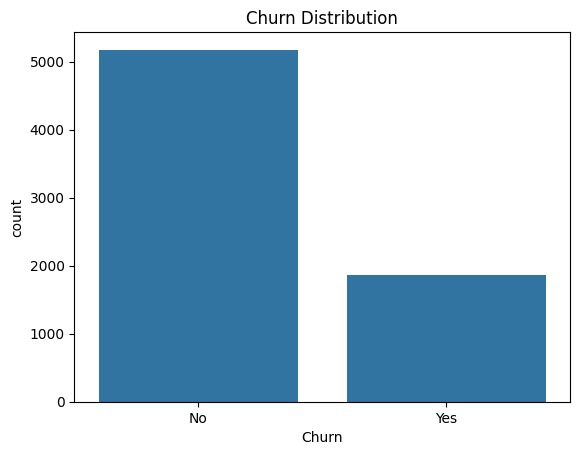

In [4]:
# plotting churn distribution graph
sns.countplot(x = 'Churn', data = df)
plt.title ('Churn Distribution')
plt.show ()

([0, 1], [Text(0, 0, 'Female'), Text(1, 0, 'Male')])

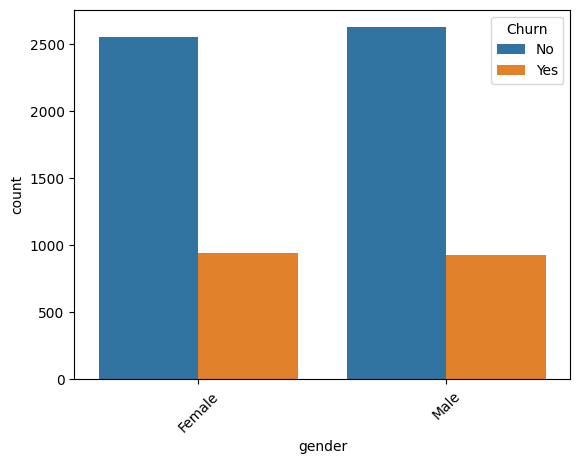

In [5]:
# male vs female churn counts
sns.countplot (x = 'gender', hue = 'Churn', data = df)
plt.xticks (rotation = 45)

([0, 1, 2, 3],
 [Text(0, 0, 'Electronic check'),
  Text(1, 0, 'Mailed check'),
  Text(2, 0, 'Bank transfer (automatic)'),
  Text(3, 0, 'Credit card (automatic)')])

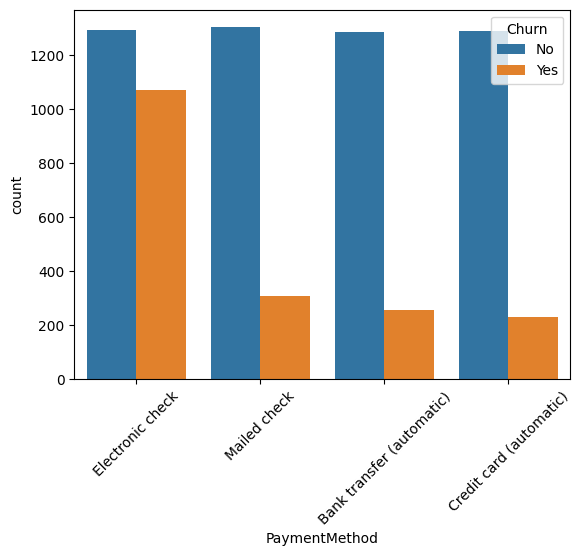

In [6]:
# payment method churn counts
sns.countplot (x = 'PaymentMethod', hue = 'Churn', data = df)
plt.xticks (rotation = 45)

([0, 1, 2],
 [Text(0, 0, 'No phone service'), Text(1, 0, 'No'), Text(2, 0, 'Yes')])

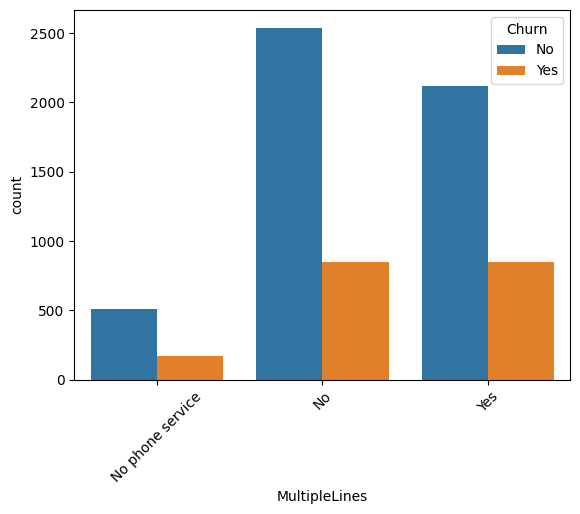

In [7]:
# multiple lines churn counts
sns.countplot (x = 'MultipleLines', hue = 'Churn', data = df)
plt.xticks (rotation = 45)

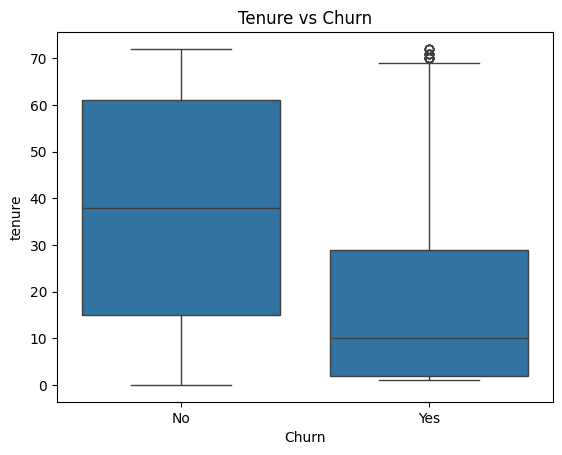

In [8]:
# tenure vs churn
sns.boxplot (x = 'Churn', y = 'tenure', data = df)
plt.title ('Tenure vs Churn')
plt.show()

In [9]:
# Converting TotalCharges to numeric (handle errors)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Handling missing values 
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# Encoding target variable
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Identifying categorical columns (excluding target)
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

# Creating preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), cat_cols)
    ],
    remainder='passthrough'
)

X = df.drop('Churn', axis=1)
y = df['Churn']

C:\Users\vijay\AppData\Local\Temp\ipykernel_3236\3364280296.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


In [10]:
# spliting the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # Important for imbalanced classes
)

In [11]:
# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Getting feature names
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)
all_features = np.concatenate([cat_features, X.columns.difference(cat_cols)])

In [12]:
# Handling class imbalance
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

model = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,  # Critical for churn prediction
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='auc'
)

model.fit(X_train_processed, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

In [13]:
# evaluating the model

y_pred = model.predict(X_test_processed)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Feature Importance
importance = pd.Series(model.feature_importances_, index=all_features)
print(importance.sort_values(ascending=False).head(10))

Accuracy: 0.7601135557132718

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.77      0.82      1035
           1       0.53      0.74      0.62       374

    accuracy                           0.76      1409
   macro avg       0.71      0.75      0.72      1409
weighted avg       0.80      0.76      0.77      1409


Confusion Matrix:
 [[793 242]
 [ 96 278]]
Contract_Two year                     0.259514
InternetService_Fiber optic           0.169685
Contract_One year                     0.105447
InternetService_No                    0.094906
OnlineSecurity_No internet service    0.044932
StreamingMovies_Yes                   0.033880
OnlineBackup_No internet service      0.030255
PaymentMethod_Electronic check        0.023828
SeniorCitizen                         0.020754
OnlineSecurity_Yes                    0.017956
dtype: float32


In [14]:
# Adjusting threshold to focus on reducing false negatives
y_proba = model.predict_proba(X_test_processed)[:, 1]
y_pred_adjusted = (y_proba > 0.4).astype(int)  # Default is 0.5

In [15]:
# Saving the model
joblib.dump(model, 'xgboost_churn_model.pkl')
joblib.dump(preprocessor, 'preprocessor.pkl')

['preprocessor.pkl']